In [1]:
##############################################
## uncomment this piece of code to use the script in Google Colab
from google.colab import drive
drive.mount('/content/drive')
##############################################

Mounted at /content/drive


In [2]:
#### Importing libraries
import os
import numpy as np
import tensorflow.keras
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing, metrics
from sklearn.model_selection import GroupKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1DTranspose, Conv1D, TimeDistributed, RepeatVector
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow_datasets import as_numpy
from collections import Counter


In [3]:
#### Constants and variables

FS = 125  # sampling frequency
N_SAMPLES = FS * 120 * 1 # n samples for each segment (125 Hz x 120 s)
N_CLASSES = 2 # control,sepsis
LABEL_CONTROL = 0
LABEL_SEPSIS = 1
RANDOM_STATE = 0
PATIENTS_TO_ADD_TO_SEPSIS_VALID_SET = 4   # number of patients taken from the sepsis training set added to the sepsis validation set
PATIENTS_TO_ADD_TO_SEPSIS_TEST_SET = 10   # number of patients taken from the sepsis training set added to the sepsis test set

In [4]:
# creates an array containing the labels of the instances in the specified path
def create_label(data_path):
  labels=[]
  for item in data_path:
    group = item.split(os.path.sep)[-2]

    if group not in ['control', 'sepsis']:
      raise Exception(f'Invalid group: {group}')

    if 'control'in group:
      labels.append(LABEL_CONTROL)
    else:
      labels.append(LABEL_SEPSIS)
  return labels

In [5]:
# loads the datasets instances from the path (x) and assigns them their label
def load_files(x,y):
   x = np.load(x)
   x = np.reshape(x,(x.size,1))
   y = to_categorical(y,num_classes=N_CLASSES)
   return x, y

In [6]:
# used to group windows of the same patient
def get_id(data_path):
  sub_ids=[]
  for item in data_path:
    file_name = item.split(os.path.sep)[-1]
    sub_id = file_name.split('_')[0]
    if not sub_id.startswith('p'):
      raise Exception(f'Subject name has to start with "p", for example P012345. Found {sub_id}')
    sub_ids.append(sub_id)
  return sub_ids

In [7]:
# creates all the datasets
def create_dataset(X_train_control, y_train_control,
                   X_train_sepsis, y_train_sepsis,
                   X_val_control, y_val_control,
                   X_val_sepsis, y_val_sepsis,
                   X_test_control, y_test_control,
                   X_test_sepsis, y_test_sepsis):

  ds_train_control = tf.data.Dataset.from_tensor_slices((X_train_control, y_train_control))
  ds_train_sepsis = tf.data.Dataset.from_tensor_slices((X_train_sepsis, y_train_sepsis))
  ds_valid_control = tf.data.Dataset.from_tensor_slices((X_val_control, y_val_control))
  ds_valid_sepsis = tf.data.Dataset.from_tensor_slices((X_val_sepsis, y_val_sepsis))
  ds_test_control = tf.data.Dataset.from_tensor_slices((X_test_control, y_test_control))
  ds_test_sepsis = tf.data.Dataset.from_tensor_slices((X_test_sepsis, y_test_sepsis))

  # Train datasets
  ds_train_control = ds_train_control.map(lambda filepath, label: tf.numpy_function(
        load_files, [filepath, label], (tf.double, tf.float32)))
  ds_train_sepsis = ds_train_sepsis.map(lambda filepath, label: tf.numpy_function(
        load_files, [filepath, label], (tf.double, tf.float32)))

  # Validation datasets
  ds_valid_control = ds_valid_control.map(lambda filepath, label: tf.numpy_function(
        load_files, [filepath, label], (tf.double, tf.float32)))

  ds_valid_sepsis = ds_valid_sepsis.map(lambda filepath, label: tf.numpy_function(
        load_files, [filepath, label], (tf.double, tf.float32)))

  # Test datasets
  ds_test_control = ds_test_control.map(lambda filepath, label: tf.numpy_function(
        load_files, [filepath, label], (tf.double, tf.float32)))

  ds_test_sepsis = ds_test_sepsis.map(lambda filepath, label: tf.numpy_function(
        load_files, [filepath, label], (tf.double, tf.float32)))


  return ds_train_control, ds_train_sepsis, ds_valid_control, ds_valid_sepsis, ds_test_control, ds_test_sepsis


In [8]:
# removes the labels column
def remove_label(features, labels):
    return features

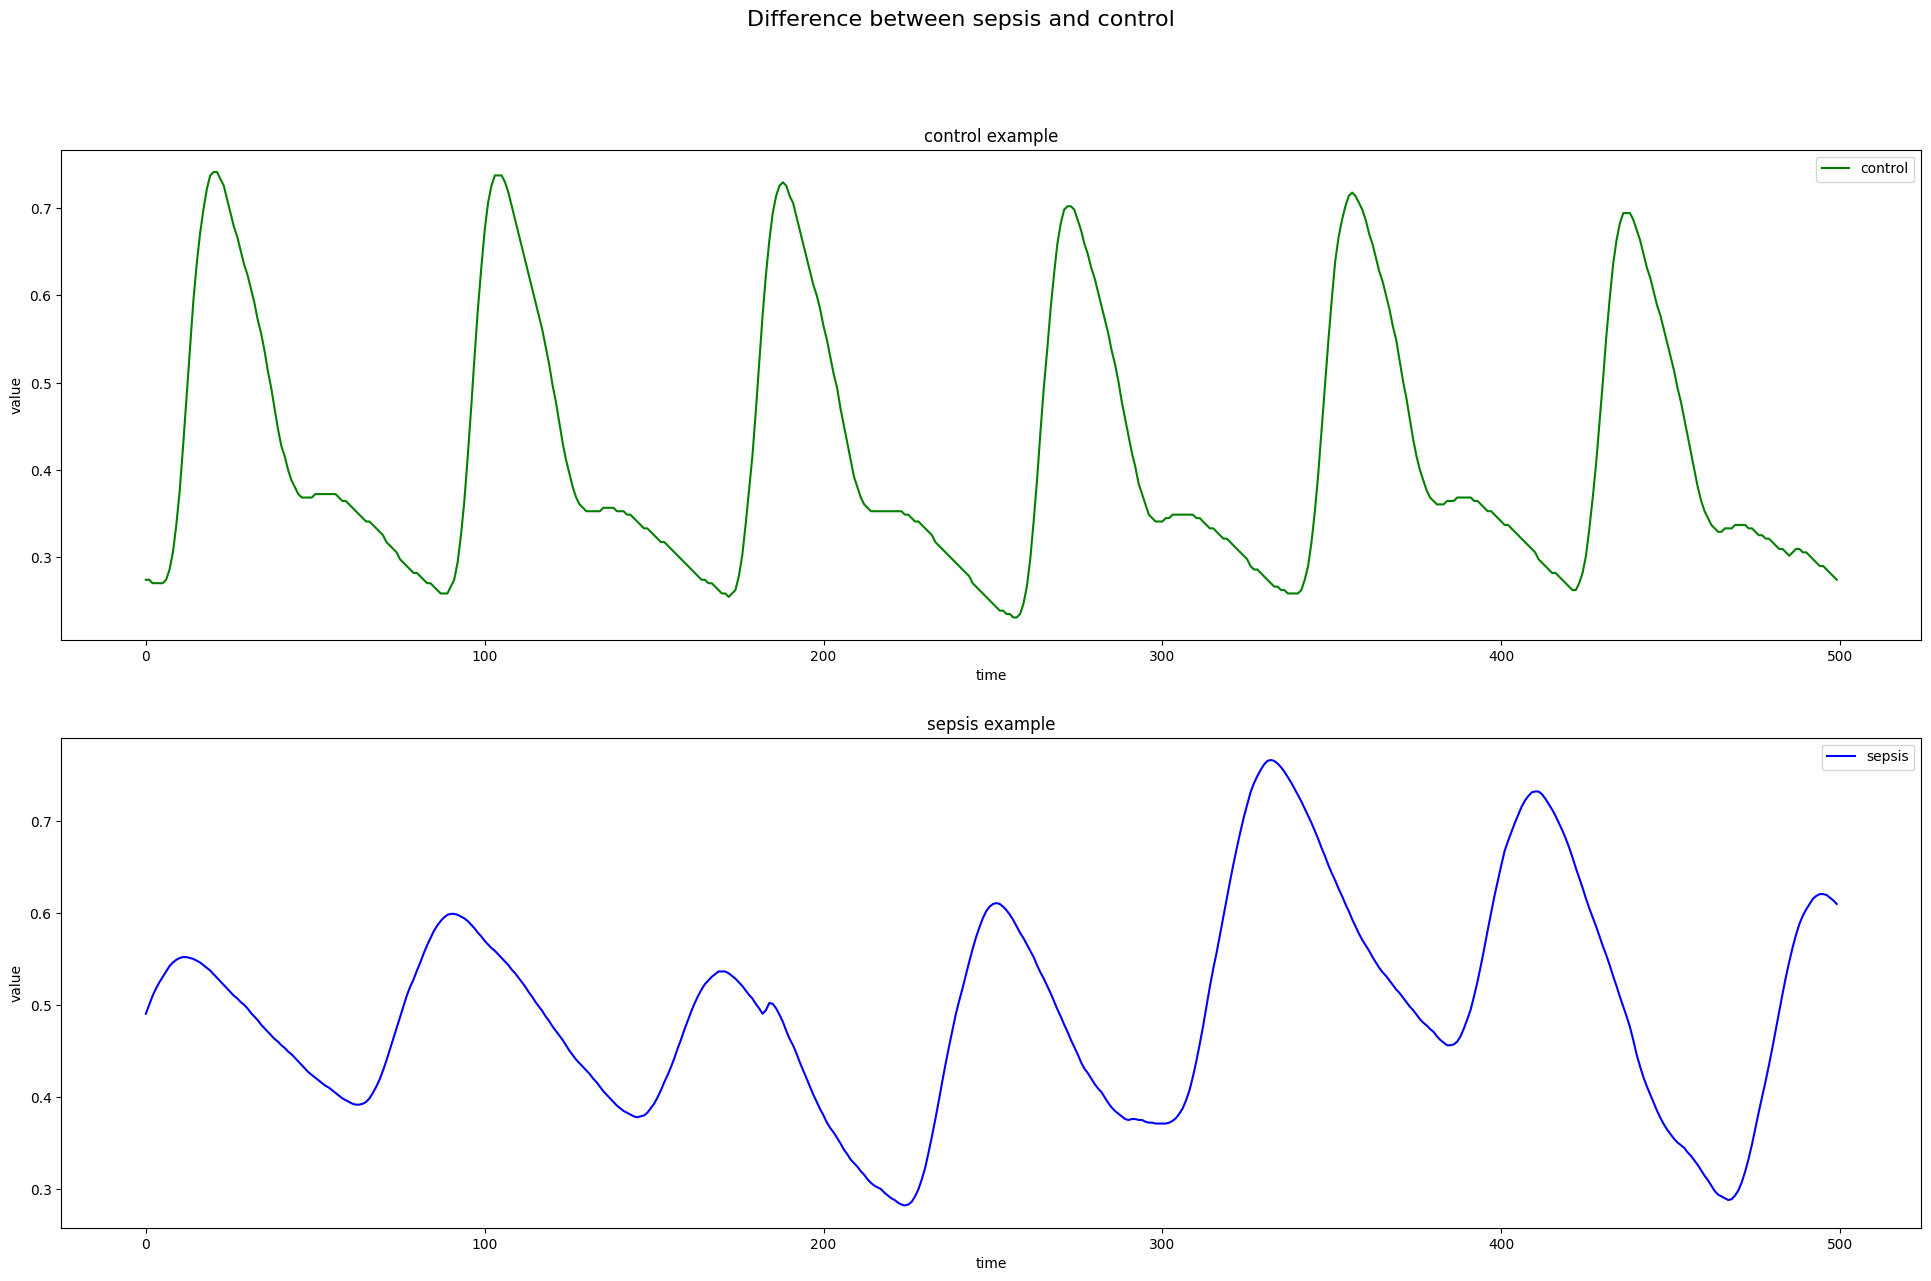

In [9]:
#### PLOT DIFFERENCES BETWEEN SEPSIS AND CONTROL ####

sepsis_file_path = "drive/MyDrive/train/sepsis/p008929_#15.npy"
control_file_path = "drive/MyDrive/train/control/p001457_#30.npy"

sepsis_loaded_data = np.load(sepsis_file_path)
control_loaded_data = np.load(control_file_path)

sepsis_show_data = sepsis_loaded_data[1000:-13500]
control_show_data = control_loaded_data[1000:-13500]

x = np.arange(len(sepsis_show_data))

fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(24, 14))

ax1.plot(x, sepsis_show_data, label='sepsis', color='blue')
ax1.set_title('sepsis example')
ax1.set_xlabel('time')
ax1.set_ylabel('value')
ax1.legend()

ax2.plot(x, control_show_data, label='control', color='green')
ax2.set_title('control example')
ax2.set_xlabel('time')
ax2.set_ylabel('value')
ax2.legend()

fig.suptitle('Difference between sepsis and control', fontsize=16)
plt.show()


In [10]:
#### DATASETS PATHS
train_control_data_paths = glob("drive/MyDrive/train/control/*.npy")
train_sepsis_data_paths = glob("drive/MyDrive/train/sepsis/*.npy")
validation_control_data_paths = glob("drive/MyDrive/validation/control/*.npy")
validation_sepsis_data_paths = glob("drive/MyDrive/validation/sepsis/*.npy")
test_control_data_paths = glob("drive/MyDrive/test/control/*.npy")
test_sepsis_data_paths = glob("drive/MyDrive/test/sepsis/*.npy")

#### CREATE DATASET ####
train_control_labels = create_label(train_control_data_paths)
train_sepsis_labels = create_label(train_sepsis_data_paths)
validation_control_labels = create_label(validation_control_data_paths)
validation_sepsis_labels = create_label(validation_sepsis_data_paths)
test_control_labels = create_label(test_control_data_paths)
test_sepsis_labels = create_label(test_sepsis_data_paths)

# sorting and grouping windows of the same patient
# X_..._ids variables contain tuples like: [patient_id, number_of_windows_of_the_patient]

X_train_control = np.sort(np.asarray(train_control_data_paths))
y_train_control = np.asarray(train_control_labels)
X_train_control_ids = get_id(X_train_control)
X_train_control_occurrences = Counter(X_train_control_ids)
X_train_control_ids = [[element, X_train_control_occurrences[element]] for element in set(X_train_control_ids)]

X_train_sepsis = np.sort(np.asarray(train_sepsis_data_paths))
y_train_sepsis = np.asarray(train_sepsis_labels)
X_train_sepsis_ids = get_id(X_train_sepsis)
X_train_sepsis_occurrences = Counter(X_train_sepsis_ids)
X_train_sepsis_ids = [[element, X_train_sepsis_occurrences[element]] for element in set(X_train_sepsis_ids)]

X_val_control = np.sort(np.asarray(validation_control_data_paths))
y_val_control = np.asarray(validation_control_labels)
X_val_control_ids = get_id(X_val_control)
X_val_control_occurrences = Counter(X_val_control_ids)
X_val_control_ids = [[element, X_val_control_occurrences[element]] for element in set(X_val_control_ids)]

X_val_sepsis = np.sort(np.asarray(validation_sepsis_data_paths))
y_val_sepsis = np.asarray(validation_sepsis_labels)
X_val_sepsis_ids = get_id(X_val_sepsis)
X_val_sepsis_occurrences = Counter(X_val_sepsis_ids)
X_val_sepsis_ids = [[element, X_val_sepsis_occurrences[element]] for element in set(X_val_sepsis_ids)]

X_test_control = np.sort(np.asarray(test_control_data_paths))
y_test_control = np.asarray(test_control_labels)
X_test_control_ids = get_id(X_test_control)
X_test_control_occurrences = Counter(X_test_control_ids)
X_test_control_ids = [[element, X_test_control_occurrences[element]] for element in set(X_test_control_ids)]

X_test_sepsis = np.sort(np.asarray(test_sepsis_data_paths))
y_test_sepsis = np.asarray(test_sepsis_labels)
X_test_sepsis_ids = get_id(X_test_sepsis)
X_test_sepsis_occurrences = Counter(X_test_sepsis_ids)
X_test_sepsis_ids = [[element, X_test_sepsis_occurrences[element]] for element in set(X_test_sepsis_ids)]


ds_train_control, ds_train_sepsis, ds_valid_control, ds_valid_sepsis, ds_test_control, ds_test_sepsis = create_dataset(
    X_train_control, y_train_control,
    X_train_sepsis, y_train_sepsis,
    X_val_control, y_val_control,
    X_val_sepsis, y_val_sepsis,
    X_test_control, y_test_control,
    X_test_sepsis, y_test_sepsis)

# removing the labels from the datasets
ds_train_control = ds_train_control.map(remove_label)
ds_train_sepsis = ds_train_sepsis.map(remove_label)
ds_valid_control = ds_valid_control.map(remove_label)
ds_valid_sepsis = ds_valid_sepsis.map(remove_label)
ds_test_control = ds_test_control.map(remove_label)
ds_test_sepsis = ds_test_sepsis.map(remove_label)

# values are normalized using a MinMaxScaler

train_control_tensor = list(ds_train_control)
training_dataset = np.array([tensor.numpy() for tensor in train_control_tensor])
scaler = MinMaxScaler()
training_dataset_shape = training_dataset.shape
training_dataset = scaler.fit_transform(training_dataset.reshape(-1, 1))
training_dataset = training_dataset.reshape(training_dataset_shape)
print("training (control) dataset shape: " + str(training_dataset.shape))
print("consisting of " + str(len(X_train_control_ids)) + " patients")

train_sepsis_tensor = list(ds_train_sepsis)
training_sepsis_array = np.array([tensor.numpy() for tensor in train_sepsis_tensor])
#training_sepsis_array_shape = training_sepsis_array.shape
#training_sepsis_array = scaler.transform(training_sepsis_array.reshape(-1, 1))
#training_sepsis_array = training_sepsis_array.reshape(training_sepsis_array_shape)
#print("training (sepsis) dataset shape: " + str(training_sepsis_array.shape))
#print("consisting of " + str(len(X_train_sepsis_ids)) + " patients")

valid_control_tensor = list(ds_valid_control)
validation_control_dataset = np.array([tensor.numpy() for tensor in valid_control_tensor])
validation_control_dataset_shape = validation_control_dataset.shape
validation_control_dataset = scaler.transform(validation_control_dataset.reshape(-1, 1))
validation_control_dataset = validation_control_dataset.reshape(validation_control_dataset_shape)
print("validation (control) dataset shape: " + str(validation_control_dataset.shape))
print("consisting of " + str(len(X_val_control_ids)) + " patients")

valid_sepsis_tensor = list(ds_valid_sepsis)
validation_sepsis_dataset = np.array([tensor.numpy() for tensor in valid_sepsis_tensor])
# adding some patients to the validation sepsis dataset
rows_count = 0
for i in range(len(X_train_sepsis_ids)):
  if i >=PATIENTS_TO_ADD_TO_SEPSIS_VALID_SET:
    break
  else:
    X_val_sepsis_ids.append(X_train_sepsis_ids[i])
    rows_n = X_train_sepsis_ids[i][1]
    patient_rows = training_sepsis_array[rows_count : rows_count+rows_n]
    validation_sepsis_dataset = np.concatenate((validation_sepsis_dataset, patient_rows), axis=0)
    rows_count += rows_n
validation_sepsis_dataset_shape = validation_sepsis_dataset.shape
validation_sepsis_dataset = scaler.transform(validation_sepsis_dataset.reshape(-1, 1))
validation_sepsis_dataset = validation_sepsis_dataset.reshape(validation_sepsis_dataset_shape)
print("validation (sepsis) dataset shape: " + str(validation_sepsis_dataset.shape))
print("consisting of " + str(len(X_val_sepsis_ids)) + " patients")

test_control_tensor = list(ds_test_control)
test_control_dataset = np.array([tensor.numpy() for tensor in test_control_tensor])
test_control_dataset_shape = test_control_dataset.shape
test_control_dataset = scaler.transform(test_control_dataset.reshape(-1, 1))
test_control_dataset = test_control_dataset.reshape(test_control_dataset_shape)
print("test (control) dataset shape: " + str(test_control_dataset.shape))
print("consisting of " + str(len(X_test_control_ids)) + " patients")

test_sepsis_tensor = list(ds_test_sepsis)
test_sepsis_dataset = np.array([tensor.numpy() for tensor in test_sepsis_tensor])
# adding some patients to the validation sepsis dataset
for i in range(PATIENTS_TO_ADD_TO_SEPSIS_VALID_SET, len(X_train_sepsis_ids)):
  if i >=(PATIENTS_TO_ADD_TO_SEPSIS_VALID_SET + PATIENTS_TO_ADD_TO_SEPSIS_TEST_SET):
    break
  else:
    X_test_sepsis_ids.append(X_train_sepsis_ids[i])
    rows_n = X_train_sepsis_ids[i][1]
    patient_rows = training_sepsis_array[rows_count : rows_count+rows_n]
    test_sepsis_dataset = np.concatenate((test_sepsis_dataset, patient_rows), axis=0)
    rows_count += rows_n
test_sepsis_dataset_shape = test_sepsis_dataset.shape
test_sepsis_dataset = scaler.transform(test_sepsis_dataset.reshape(-1, 1))
test_sepsis_dataset = test_sepsis_dataset.reshape(test_sepsis_dataset_shape)
print("test (sepsis) dataset shape: " + str(test_sepsis_dataset.shape))
print("consisting of " + str(len(X_test_sepsis_ids)) + " patients")


training (control) dataset shape: (2772, 15000, 1)
consisting of 95 patients
validation (control) dataset shape: (390, 15000, 1)
consisting of 13 patients
validation (sepsis) dataset shape: (419, 15000, 1)
consisting of 14 patients
test (control) dataset shape: (810, 15000, 1)
consisting of 27 patients
test (sepsis) dataset shape: (878, 15000, 1)
consisting of 30 patients


In [11]:
#### CREATE MODEL ####
model = []

# specifies if the autoencoder model has to be created with lstm layers
# (or with convolutional ones -> if USE_LSTM_LAYERS == False)
USE_LSTM_LAYERS = True


if USE_LSTM_LAYERS:

  outer_lstm_units = 128 # units number of the outer layers
  inner_lstm_units = 64 # units number of the inner layers

  # encoding part of the model
  encoder = Sequential([
    Input(shape=(N_SAMPLES, 1)),
    LSTM(units=outer_lstm_units, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(units=inner_lstm_units, return_sequences=True),
    Dropout(rate=0.2)
  ], name="encoder")

   # decoding part of the model
  decoder = Sequential([
    LSTM(units=inner_lstm_units, return_sequences=True),
    Dropout(rate=0.2),
    LSTM(units=outer_lstm_units, return_sequences=True),
    Dropout(rate=0.2),
    TimeDistributed(Dense(units=1))
  ], name="decoder")

  # autoencoder model
  model = Sequential([
    encoder,
    decoder
  ], name="LSTMAutoencoder")

else:   ## MODEL CREATED WITH CONVOLUTIONAL LAYERS

  model = Sequential([

    Input(shape=(N_SAMPLES, 1)),

    Conv1D(filters=128, kernel_size=7, padding="same", strides=2,
            activation="relu"),

    Dropout(rate=0.2),

    Conv1D(filters=64, kernel_size=7, padding="same", strides=2,
            activation="relu"),

    Conv1DTranspose(filters=64, kernel_size=7, padding="same",
                    strides=2, activation="relu"),

    Dropout(rate=0.2),

    Conv1DTranspose(filters=128, kernel_size=7, padding="same",
                    strides=2, activation="relu"),

    Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
  ])

Model: "LSTMAutoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 15000, 64)         115968    
                                                                 
 decoder (Sequential)        (None, 15000, 1)          131969    
                                                                 
Total params: 247937 (968.50 KB)
Trainable params: 247937 (968.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15000, 128)        66560     
                                                                 
 dropout (Dropout)           (None, 15000, 128)        0         
                                                           

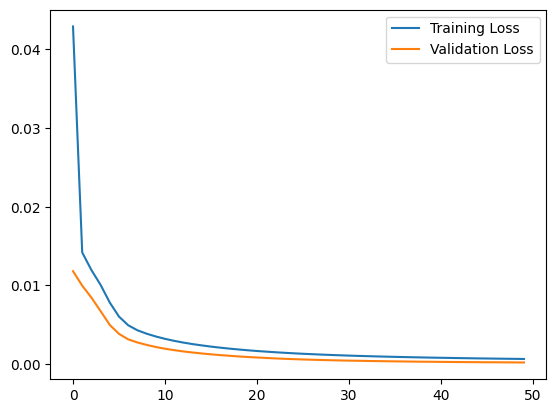

In [12]:
#### TRAIN MODEL ####

# parameters of the training process
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 50
VALIDATION_SPLIT = 0.2  # percentage of the training data to use as validation
loss_function = "mse"

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=loss_function)
model.build((None, N_SAMPLES, 1))

# summary of the model
model.summary()
print()

if USE_LSTM_LAYERS:
  encoder_model = model.layers[0]
  encoder_model.summary()
  print()
  decoder_model = model.layers[1]
  decoder_model.summary()
  print()

# training
history = model.fit(
  training_dataset,
  training_dataset,
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  validation_split=VALIDATION_SPLIT,
  callbacks=[
      EarlyStopping(monitor="val_loss", patience=5, mode="min")
  ],
)

# plot training loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


In [13]:
#################
## SAVE MODEL
model.save('./drive/MyDrive/autoencoder.keras')
#################

In [14]:
#################
## LOAD MODEL
model = tf.keras.saving.load_model('./drive/MyDrive/autoencoder.keras')
#################

87/87 [==============================] - 59s 653ms/step
Reconstruction error threshold:  0.0029075508264888583


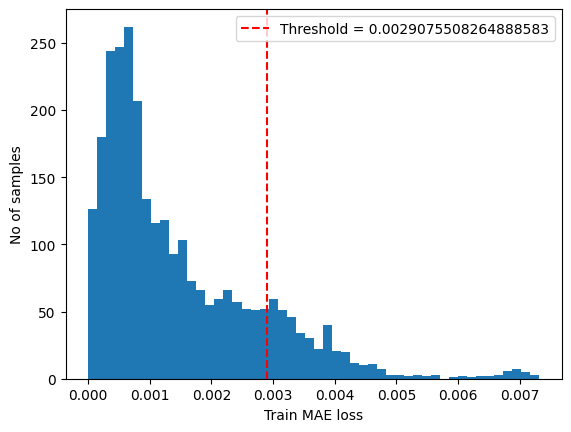

In [15]:
#### ESTIMATE THRESHOLD FOR CLASSIFICATION ####

# needed to find a threshold
# specifies how many prediction losses of the training set have to be below the threshold
# and the loss of this nh element is used as threshold
threshold_percentage = 0.85

# number of windows predicted as sepsis after which the patient is precticted as sepsis
threshold_number = 1

# computing the loss on the training set
X_train_control_pred = model.predict(training_dataset)

train_loss = (np.sqrt(np.mean((X_train_control_pred - training_dataset), axis=1)**2)).flatten()
#train_loss = (np.mean(np.abs(X_train_control_pred - training_dataset), axis=1)).flatten()

# obtaining the threshold to be used in classification
#threshold = np.max(train_loss)
train_loss = np.sort(train_loss)
index_threshold = int(len(train_loss) * threshold_percentage)
threshold = train_loss[index_threshold]
print("Reconstruction error threshold: ", threshold)

# plotting the distribution of the losses in the training set
plt.hist(train_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.show()

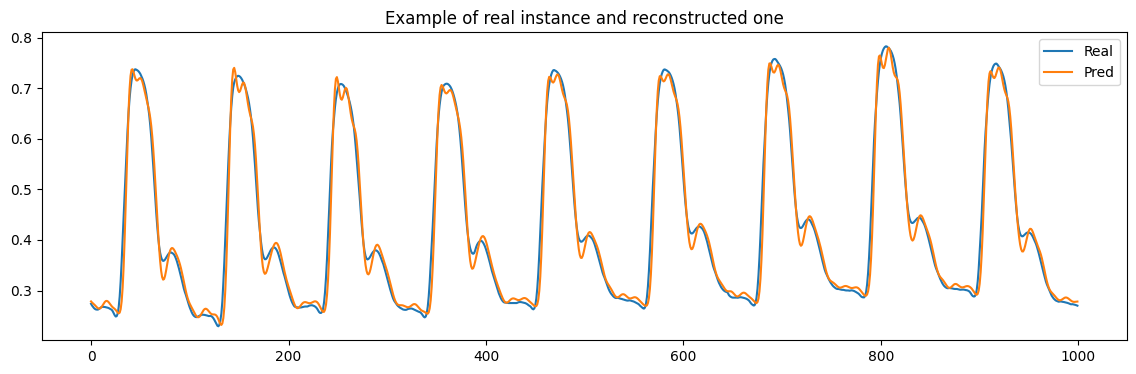

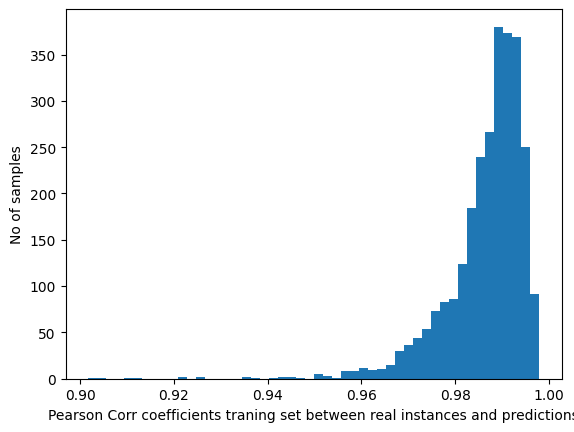

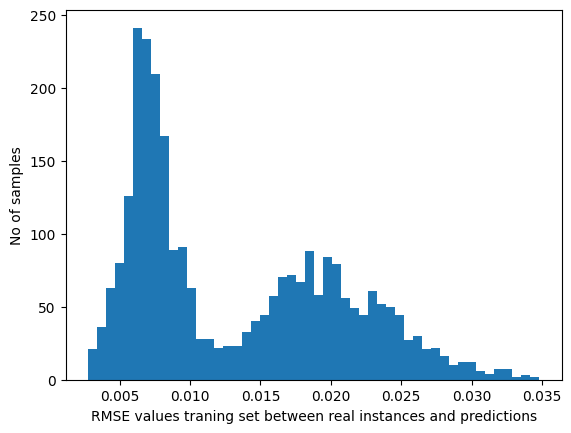

In [16]:
# showing the difference between a reconstruction of the model
# and the real value of an instance of the training set

plt.figure(figsize=(14, 4))
plt.title("Example of real instance and reconstructed one")
real = training_dataset[500][12000:13000]
pred = X_train_control_pred[500][12000:13000]
plt.plot(real, label="Real")
plt.plot(pred, label="Pred")
plt.legend()
plt.show()

"""real_reshaped = np.reshape(real, (real.shape[0], real.shape[1]))
pred_reshaped = np.reshape(pred, (real.shape[0], real.shape[1]))
pearson_corr = np.corrcoef(real_reshaped[i], pred_reshaped[i])[0, 1]
rmse = np.sqrt(np.mean((real_reshaped[i] - pred_reshaped[i])**2))
print("Pearson correlation coefficient of this example: " + str(pearson_corr))
print("RMSE of this example: " + str(rmse))"""

training_dataset_reshaped = np.reshape(training_dataset, (training_dataset.shape[0], training_dataset.shape[1]))
X_train_control_pred_reshaped = np.reshape(X_train_control_pred, (training_dataset.shape[0], training_dataset.shape[1]))

# computes the Pearson correlation coefficient and the RMSE between each instance
# of the training set and the output value the model
correlation_coefficients = []
rmse_values = []
for i in range(training_dataset.shape[0]):
    pearson_corr = np.corrcoef(training_dataset_reshaped[i], X_train_control_pred_reshaped[i])[0, 1]
    correlation_coefficients.append(pearson_corr)

    rmse = np.sqrt(np.mean((training_dataset_reshaped[i] - X_train_control_pred_reshaped[i])**2))
    rmse_values.append(rmse)

# plotting Pearson Correlation Coefficients distribution
plt.hist(correlation_coefficients, bins=50)
plt.xlabel("Pearson Corr coefficients traning set between real instances and predictions")
plt.ylabel("No of samples")
plt.show()

# plotting RMSE values distribution
plt.hist(rmse_values, bins=50)
plt.xlabel("RMSE values traning set between real instances and predictions")
plt.ylabel("No of samples")
plt.show()

In [17]:
## show reconstruction examples
"""plt.figure(figsize=(14, 4))
plt.title("Example of real instance and reconstructed one")
real = training_dataset[200][12000:13000]
pred = X_train_control_pred[200][12000:13000]
plt.plot(real, label="Real")
plt.plot(pred, label="Pred")
plt.legend()
plt.show()
"""

'plt.figure(figsize=(14, 4))\nplt.title("Example of real instance and reconstructed one")\nreal = training_dataset[200][12000:13000]\npred = X_train_control_pred[200][12000:13000]\nplt.plot(real, label="Real")\nplt.plot(pred, label="Pred")\nplt.legend()\nplt.show()\n'

In [18]:
# can be used to change the threshold manually
#threshold = 0.18

13/13 [==============================] - 9s 684ms/step
Correct control predictions on validation set: 370/390
[['p008281', 0, 0], ['p041929', 0, 0], ['p046611', 0, 0], ['p065370', 0, 0], ['p027555', 15, 29], ['p051687', 0, 0], ['p055363', 0, 0], ['p016640', 0, 0], ['p071013', 0, 0], ['p075369', 0, 0], ['p097028', 1, 0], ['p086662', 0, 0], ['p050384', 4, 25]]


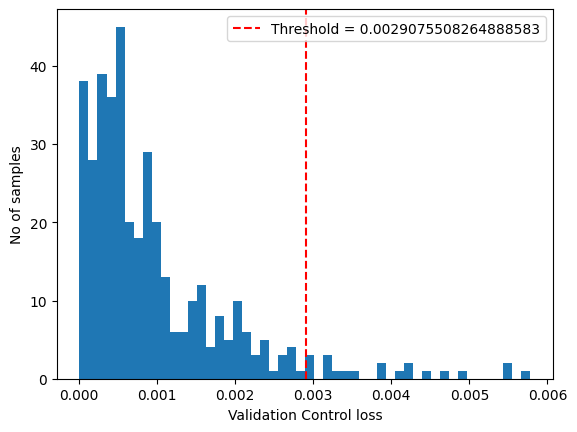

14/14 [==============================] - 9s 654ms/step
Correct sepsis predictions on validation set: 31/419
[['p072328', 0, 0], ['p044207', 0, 0], ['p079306', 0, 0], ['p053812', 0, 0], ['p068475', 0, 0], ['p099115', 0, 0], ['p083678', 0, 0], ['p093596', 30, 29], ['p060262', 0, 0], ['p046254', 1, 29], ['p055393', 0, 0], ['p088466', 0, 0], ['p098582', 0, 0], ['p095776', 0, 0]]


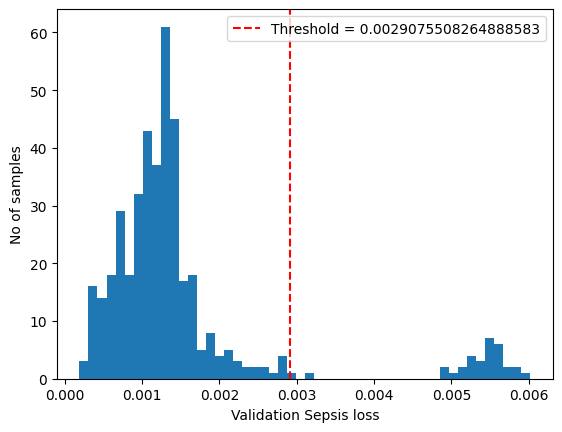

'validation_sepsis_dataset_reshaped = np.reshape(validation_sepsis_dataset, (validation_sepsis_dataset.shape[0], validation_sepsis_dataset.shape[1]))\nsepsis_pred_reshaped = np.reshape(sepsis_pred, (validation_sepsis_dataset.shape[0], validation_sepsis_dataset.shape[1]))\n\n# computes the Pearson correlation coefficient and the RMSE between each instance\n# of the validation sepsis set and the output value the model\ncorrelation_coefficients = []\nrmse_values = []\nfor i in range(validation_sepsis_dataset.shape[0]):\n    pearson_corr = np.corrcoef(validation_sepsis_dataset_reshaped[i], sepsis_pred_reshaped[i])[0, 1]\n    correlation_coefficients.append(pearson_corr)\n\n    rmse = np.sqrt(np.mean((validation_sepsis_dataset_reshaped[i] - sepsis_pred_reshaped[i])**2))\n    rmse_values.append(rmse)\n\n# plotting Pearson Correlation Coefficients distribution\nplt.hist(correlation_coefficients, bins=50)\nplt.xlabel("Pearson Corr coefficients traning set between real instances and predictions

In [19]:
#### VALIDATION ON CONTROL LABEL ####

# computing the loss on the control validation dataset
control_pred = model.predict(validation_control_dataset)
control_pred_losses = (np.sqrt(np.mean((control_pred - validation_control_dataset), axis=1)**2)).flatten()
#control_pred_losses = (np.mean(np.abs(control_pred - validation_control_dataset), axis=1)).flatten()

# evaluating the performances
correct_control = sum(l <= threshold for l in control_pred_losses)
print("Correct control predictions on validation set: " + str(correct_control) + "/" + str(len(validation_control_dataset)))

## DIVIDING PREDICTIONS PER PATIENT
count = 0
## array containing predictions
## elements have the form: [patient_id, number_of_instances_predicted_as_sepsis, windows_remaining_after_sepsis_prediction]
validation_control_predictions = []
for i in range(len(X_val_control_ids)):
  sepsis_predictions_number = 0
  instances_remaining = 0
  for j in range(X_val_control_ids[i][1]):
    if control_pred_losses[count] > threshold:
      sepsis_predictions_number+=1
      if sepsis_predictions_number == threshold_number:
        instances_remaining = X_val_control_ids[i][1] - j - 1
        #break
    count +=1
  validation_control_predictions.append([X_val_control_ids[i][0], sepsis_predictions_number, instances_remaining])

print(validation_control_predictions)

# plotting the loss distribution
plt.hist(control_pred_losses, bins=50)
plt.xlabel("Validation Control loss")
plt.ylabel("No of samples")
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.show()


#### VALIDATION ON SEPSIS LABEL ####

# computing the loss on the control test dataset
sepsis_pred = model.predict(validation_sepsis_dataset)
sepsis_pred_losses = (np.sqrt(np.mean((sepsis_pred - validation_sepsis_dataset), axis=1)**2)).flatten()
#sepsis_pred_losses = (np.mean(np.abs(sepsis_pred - validation_sepsis_dataset), axis=1)).flatten()

# evaluating the performances
correct_sepsis = sum(l > threshold for l in sepsis_pred_losses)
print("Correct sepsis predictions on validation set: " + str(correct_sepsis) + "/" + str(len(validation_sepsis_dataset)))

## DIVIDING PREDICTIONS PER PATIENT
count = 0
# array containing predictions
# elements have the form: [patient_id, number_of_instances_predicted_as_sepsis, windows_remaining_after_sepsis_prediction]
validation_sepsis_predictions = []
for i in range(len(X_val_sepsis_ids)):
  sepsis_predictions_number = 0
  instances_remaining = 0
  for j in range(X_val_sepsis_ids[i][1]):
    if sepsis_pred_losses[count] > threshold:
      sepsis_predictions_number+=1
      if sepsis_predictions_number == threshold_number:
        instances_remaining = X_val_sepsis_ids[i][1] - j - 1
        #break
    count +=1
  validation_sepsis_predictions.append([X_val_sepsis_ids[i][0], sepsis_predictions_number, instances_remaining])

print(validation_sepsis_predictions)

# plotting the loss distribution
plt.hist(sepsis_pred_losses, bins=50)
plt.xlabel("Validation Sepsis loss")
plt.ylabel("No of samples")
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.show()


### pearson corr and rmse sepsis
"""validation_sepsis_dataset_reshaped = np.reshape(validation_sepsis_dataset, (validation_sepsis_dataset.shape[0], validation_sepsis_dataset.shape[1]))
sepsis_pred_reshaped = np.reshape(sepsis_pred, (validation_sepsis_dataset.shape[0], validation_sepsis_dataset.shape[1]))

# computes the Pearson correlation coefficient and the RMSE between each instance
# of the validation sepsis set and the output value the model
correlation_coefficients = []
rmse_values = []
for i in range(validation_sepsis_dataset.shape[0]):
    pearson_corr = np.corrcoef(validation_sepsis_dataset_reshaped[i], sepsis_pred_reshaped[i])[0, 1]
    correlation_coefficients.append(pearson_corr)

    rmse = np.sqrt(np.mean((validation_sepsis_dataset_reshaped[i] - sepsis_pred_reshaped[i])**2))
    rmse_values.append(rmse)

# plotting Pearson Correlation Coefficients distribution
plt.hist(correlation_coefficients, bins=50)
plt.xlabel("Pearson Corr coefficients traning set between real instances and predictions")
plt.ylabel("No of samples")
plt.show()

# plotting RMSE values distribution
plt.hist(rmse_values, bins=50)
plt.xlabel("RMSE values traning set between real instances and predictions")
plt.ylabel("No of samples")
plt.show()
"""

In [20]:
## show reconstruction sepsis
"""
plt.figure(figsize=(14, 4))
plt.title("Example of real instance and reconstructed one")
real = validation_sepsis_dataset[200][12000:13000]
pred = sepsis_pred[200][12000:13000]
plt.plot(real, label="Real")
plt.plot(pred, label="Pred")
plt.legend()
plt.show()
"""

'\nplt.figure(figsize=(14, 4))\nplt.title("Example of real instance and reconstructed one")\nreal = validation_sepsis_dataset[200][12000:13000]\npred = sepsis_pred[200][12000:13000]\nplt.plot(real, label="Real")\nplt.plot(pred, label="Pred")\nplt.legend()\nplt.show()\n'

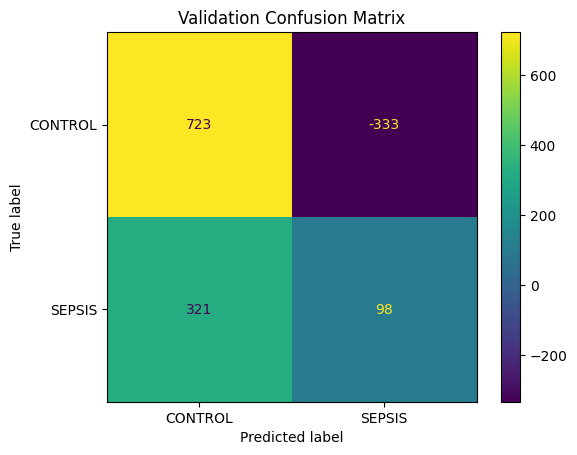

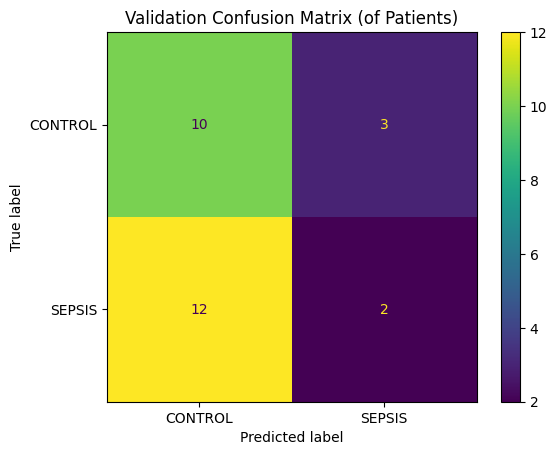

In [26]:
#### CREATE VALIDATION CONFUSION MATRIX ####

tn = correct_control
fp = len(validation_control_dataset) - correct_control

fn = len(validation_sepsis_dataset) - correct_sepsis
tp = correct_sepsis

confusion_matrix = np.ndarray(shape=(2,2), buffer=np.array([[tn, fn], [fp, tp]]), dtype=int, order='F')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["CONTROL", "SEPSIS"])

cm_display.plot(values_format='d')
plt.title("Validation Confusion Matrix")
plt.show()


#### VALIDATION CONFUSION MATRIX PER PATIENT ####
tn_p = 0
for elem in validation_control_predictions:
  if elem[1] < threshold_number:
    tn_p +=1

fp_p = len(validation_control_predictions) - tn_p

tp_p = 0
for elem in validation_sepsis_predictions:
  if elem[1] >= threshold_number:
    tp_p +=1

fn_p = len(validation_sepsis_predictions) - tp_p


confusion_matrix = np.ndarray(shape=(2,2), buffer=np.array([[tn_p, fn_p], [fp_p, tp_p]]), dtype=int, order='F')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["CONTROL", "SEPSIS"])

cm_display.plot(values_format='d')
plt.title("Validation Confusion Matrix (of Patients)")
plt.show()

In [22]:
#### COMPUTING PERFORMANCE VALIDATION SET ####
accuracy_control = correct_control / len(validation_control_dataset)
accuracy_sepsis = correct_sepsis / len(validation_sepsis_dataset)
accuracy = (correct_control + correct_sepsis) / (len(validation_control_dataset) + len(validation_sepsis_dataset))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print("accuracy validation set: " + str(accuracy))
print("precision validation set: " + str(precision))
print("recall validation set: " + str(recall))
print("F1 score validation set: " + str(f1_score))

#### COMPUTING PERFORMANCE OF PATIENTS VALIDATION SET ####
accuracy_control_p = tn_p / len(validation_control_predictions)
accuracy_sepsis_p = tp_p / len(validation_sepsis_predictions)
accuracy_p = (tn_p + tp_p) / (len(validation_control_predictions) + len(validation_sepsis_predictions))

precision_p = tp_p / (tp_p + fp_p)
recall_p = tp_p / (tp_p + fn_p)
f1_score_p = 2 * precision_p * recall_p / (precision_p + recall_p)

print("\naccuracy validation set (of patients): " + str(accuracy_p))
print("precision validation set (of patients): " + str(precision_p))
print("recall validation set (of patients): " + str(recall_p))
print("F1 score validation set (of patients): " + str(f1_score_p))

#### COMPUTING AVERAGE ANTICIPATION VALIDATION SET ####
count = 0
sum_anticipation = 0
for elem in validation_sepsis_predictions:
  if elem[1] >= 3:
    count +=1
    sum_anticipation += elem[2]

if count > 0:
  average_instances_anticipation = int(sum_anticipation/count)
  print("\nsepsis patients (validation set) are recognized with an average anticipation of " + str(average_instances_anticipation) + " time windows")



accuracy validation set: 0.4956736711990111
precision validation set: 0.6078431372549019
recall validation set: 0.07398568019093078
F1 score validation set: 0.13191489361702127

accuracy validation set (of patients): 0.4444444444444444
precision validation set (of patients): 0.3333333333333333
recall validation set (of patients): 0.07142857142857142
F1 score validation set (of patients): 0.11764705882352941

sepsis patients (validation set) are recognized with an average anticipation of 29 time windows


26/26 [==============================] - 17s 644ms/step
Correct control predictions on test set: 723/810
[['p056802', 0, 0], ['p040767', 27, 29], ['p087965', 10, 28], ['p097314', 0, 0], ['p067005', 13, 26], ['p070508', 0, 0], ['p064557', 0, 0], ['p072402', 0, 0], ['p043770', 0, 0], ['p061980', 1, 3], ['p070048', 0, 0], ['p059795', 0, 0], ['p065575', 0, 0], ['p099992', 1, 15], ['p063922', 0, 0], ['p046446', 0, 0], ['p044784', 2, 22], ['p067341', 0, 0], ['p025356', 8, 21], ['p087310', 0, 0], ['p068736', 0, 0], ['p072314', 0, 0], ['p047419', 1, 27], ['p053868', 0, 0], ['p095474', 0, 0], ['p062735', 24, 29], ['p086589', 0, 0]]


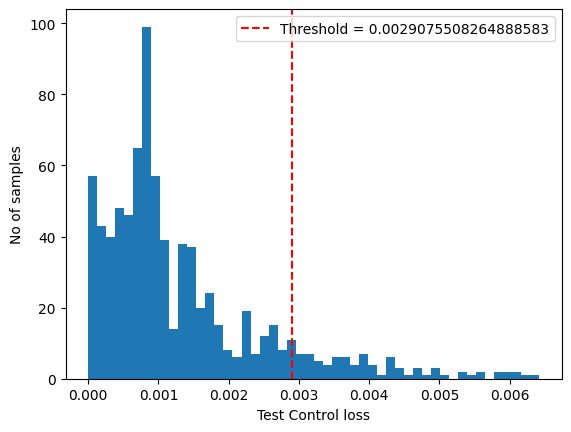

28/28 [==============================] - 18s 640ms/step
Correct sepsis predictions on test set: 98/878
[['p008915', 0, 0], ['p050450', 0, 0], ['p074866', 0, 0], ['p063944', 0, 0], ['p080737', 0, 0], ['p027636', 10, 12], ['p097599', 12, 29], ['p080644', 0, 0], ['p027833', 0, 0], ['p090878', 0, 0], ['p017875', 13, 12], ['p068095', 9, 29], ['p008141', 0, 0], ['p081449', 0, 0], ['p083203', 0, 0], ['p065112', 0, 0], ['p059285', 0, 0], ['p068860', 30, 29], ['p094997', 0, 0], ['p046092', 0, 0], ['p040833', 0, 0], ['p025915', 0, 0], ['p041588', 0, 0], ['p008929', 0, 0], ['p078292', 0, 0], ['p092916', 0, 0], ['p089854', 0, 0], ['p093566', 0, 0], ['p056963', 0, 0], ['p070447', 24, 26]]


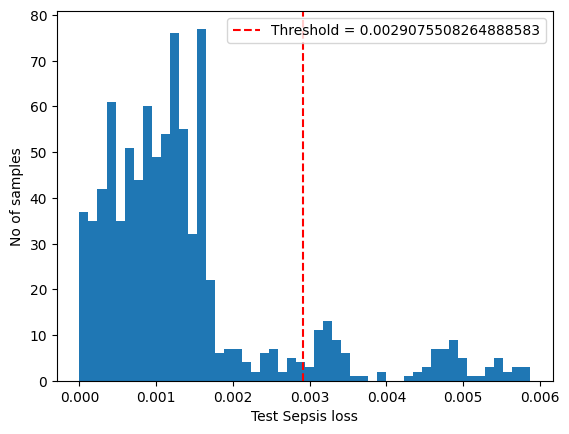

In [23]:
#### TEST ON CONTROL LABEL ####
# computing the loss on the control test dataset
control_pred = model.predict(test_control_dataset)
control_pred_losses = (np.sqrt(np.mean((control_pred - test_control_dataset), axis=1)**2)).flatten()
#control_pred_losses = (np.mean(np.abs(control_pred - test_control_dataset), axis=1)).flatten()

# evaluating the performances
correct_control = sum(l <= threshold for l in control_pred_losses)
print("Correct control predictions on test set: " + str(correct_control) + "/" + str(len(test_control_dataset)))

## DIVIDING PREDICTIONS PER PATIENT
count = 0
## array containing predictions
## elements have the form: [patient_id, number_of_instances_predicted_as_sepsis, windows_remaining_after_sepsis_prediction]
test_control_predictions = []
for i in range(len(X_test_control_ids)):
  sepsis_predictions_number = 0
  instances_remaining = 0
  for j in range(X_test_control_ids[i][1]):
    if control_pred_losses[count] > threshold:
      sepsis_predictions_number+=1
      if sepsis_predictions_number == threshold_number:
        instances_remaining = X_test_control_ids[i][1] - j - 1
        #break
    count +=1
  test_control_predictions.append([X_test_control_ids[i][0], sepsis_predictions_number, instances_remaining])

print(test_control_predictions)

# plotting the loss distribution
plt.hist(control_pred_losses, bins=50)
plt.xlabel("Test Control loss")
plt.ylabel("No of samples")
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.show()


#### TEST ON SEPSIS LABEL ####

# computing the loss on the control test dataset
sepsis_pred = model.predict(test_sepsis_dataset)
sepsis_pred_losses = (np.sqrt(np.mean((sepsis_pred - test_sepsis_dataset), axis=1)**2)).flatten()
#sepsis_pred_losses = (np.mean(np.abs(sepsis_pred - test_sepsis_dataset), axis=1)).flatten()

# evaluating the performances
correct_sepsis = sum(l > threshold for l in sepsis_pred_losses)
print("Correct sepsis predictions on test set: " + str(correct_sepsis) + "/" + str(len(test_sepsis_dataset)))

## DIVIDING PREDICTIONS PER PATIENT
count = 0
# array containing predictions
# elements have the form: [patient_id, number_of_instances_predicted_as_sepsis, windows_remaining_after_sepsis_prediction]
test_sepsis_predictions = []
for i in range(len(X_test_sepsis_ids)):
  sepsis_predictions_number = 0
  instances_remaining = 0
  for j in range(X_test_sepsis_ids[i][1]):
    if sepsis_pred_losses[count] > threshold:
      sepsis_predictions_number+=1
      if sepsis_predictions_number == threshold_number:
        instances_remaining = X_test_sepsis_ids[i][1] - j - 1
        #break
    count +=1
  test_sepsis_predictions.append([X_test_sepsis_ids[i][0], sepsis_predictions_number, instances_remaining])

print(test_sepsis_predictions)

# plotting the loss distribution
plt.hist(sepsis_pred_losses, bins=50)
plt.xlabel("Test Sepsis loss")
plt.ylabel("No of samples")
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.show()


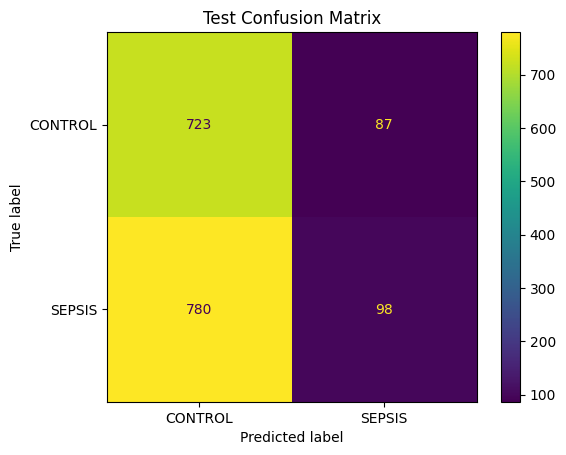

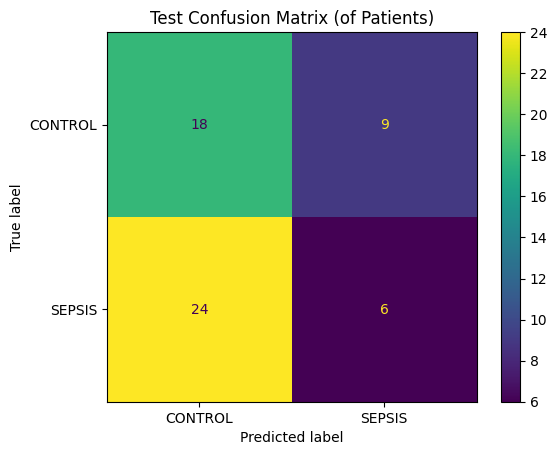

In [27]:
#### CREATE TEST CONFUSION MATRIX ####

tn = correct_control
fp = len(test_control_dataset) - correct_control

fn = len(test_sepsis_dataset) - correct_sepsis
tp = correct_sepsis

confusion_matrix = np.ndarray(shape=(2,2), buffer=np.array([[tn, fn], [fp, tp]]), dtype=int, order='F')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["CONTROL", "SEPSIS"])

cm_display.plot(values_format='d')
plt.title("Test Confusion Matrix")
plt.show()


#### TEST CONFUSION MATRIX OF PATIENTS ####
tn_p = 0
for elem in test_control_predictions:
  if elem[1] < threshold_number:
    tn_p +=1

fp_p = len(test_control_predictions) - tn_p

tp_p = 0
for elem in test_sepsis_predictions:
  if elem[1] >= threshold_number:
    tp_p +=1

fn_p = len(test_sepsis_predictions) - tp_p


confusion_matrix = np.ndarray(shape=(2,2), buffer=np.array([[tn_p, fn_p], [fp_p, tp_p]]), dtype=int, order='F')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["CONTROL", "SEPSIS"])

cm_display.plot(values_format='d')
plt.title("Test Confusion Matrix (of Patients)")
plt.show()

In [25]:
#### COMPUTING PERFORMANCE TEST SET ####
accuracy_control = correct_control / len(test_control_dataset)
accuracy_sepsis = correct_sepsis / len(test_sepsis_dataset)
accuracy = (correct_control + correct_sepsis) / (len(test_control_dataset) + len(test_sepsis_dataset))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print("accuracy test set: " + str(accuracy))
print("precision test set: " + str(precision))
print("recall test set: " + str(recall))
print("F1 score test set: " + str(f1_score))

#### COMPUTING PERFORMANCE PER PATIENT TEST SET ####
accuracy_control_p = tn_p / len(test_control_predictions)
accuracy_sepsis_p = tp_p / len(test_sepsis_predictions)
accuracy_p = (tn_p + tp_p) / (len(test_control_predictions) + len(test_sepsis_predictions))

precision_p = tp_p / (tp_p + fp_p)
recall_p = tp_p / (tp_p + fn_p)
f1_score_p = 2 * precision_p * recall_p / (precision_p + recall_p)

print("\naccuracy test set (of patients): " + str(accuracy_p))
print("precision test set (of patients): " + str(precision_p))
print("recall test set (of patients): " + str(recall_p))
print("F1 score test set (of patients): " + str(f1_score_p))

#### COMPUTING AVERAGE ANTICIPATION TEST SET ####
count = 0
sum_anticipation = 0
for elem in test_sepsis_predictions:
  if elem[1] >= 3:
    count +=1
    sum_anticipation += elem[2]

if count > 0:
  average_instances_anticipation = int(sum_anticipation/count)
  print("\nsepsis patients (test set) are recognized with an average anticipation of " + str(average_instances_anticipation) + " time windows")


accuracy test set: 0.4863744075829384
precision test set: 0.5297297297297298
recall test set: 0.11161731207289294
F1 score test set: 0.18438381937911572

accuracy test set (of patients): 0.49122807017543857
precision test set (of patients): 0.5454545454545454
recall test set (of patients): 0.2
F1 score test set (of patients): 0.29268292682926833

sepsis patients (test set) are recognized with an average anticipation of 22 time windows
